# 1. Exploring and preprocessing data

## Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# Load dữ liệu vào pandas dataframe
data = pd.read_csv('Data/FPL_tweets.csv', delimiter=',')

## Dữ liệu có bao nhiêu dòng và cột

In [3]:
number_rows, number_cols = data.shape

print(f'Dữ liệu có số dòng là: {number_rows}')
print(f'Dữ liệu có số cột là: {number_cols}')

Dữ liệu có số dòng là: 114466
Dữ liệu có số cột là: 13


## Khám phá dòng của dữ liệu

### Ý nghĩa của mỗi dòng

In [4]:
# In ra 3 dòng bất kỳ trong tập dữ liệu
data.sample(3)

,ID,Timestamp,User,Text,Hashtag,Retweets,Likes,Replies,Source,Location,Verified_Account,Followers,Following
82829,1.327160e+18,2020-11-13 08:16:07+00:00,NustaNews,"GRD vs BGR Prediction, Dream11 Fantasy Cricket...","['NustaNews', 'TodayNews', 'DailyNews', 'Break...",0,0,0,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",NaN,False,24,106
93326,1.443650e+18,2021-09-30 18:45:40+00:00,LeafyDragon_FPL,"Hello, I’m now the proud owner of Christopher ...",NaN,0,6,1,"<a href=""http://twitter.com/download/iphone"" r...",Newcastle Upon Tyne,False,2716,1043
93104,1.445070e+18,2021-10-04 16:39:01+00:00,DanielMVarela,Whatsapp esta mas caído que yo en el Fantasy d...,NaN,0,1,0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Bogotá,False,242,636


Mỗi dòng trong bảng mô tả một tweet riêng biệt, bao gồm thông tin về người đăng, nội dung tweet, tương tác và các chi tiết khác.



### Có tồn tại các dòng trùng lắp không?

In [5]:
data[data.duplicated()]

,ID,Timestamp,User,Text,Hashtag,Retweets,Likes,Replies,Source,Location,Verified_Account,Followers,Following


Dữ liệu trên không có dòng nào là trùng nhau.

## Khám phá cột của dữ liệu

### Ý nghĩa của mỗi cột

| Tên cột  | Ý nghĩa  |
|---|---|
| ID  | Mã định danh độc nhất cho mỗi tweet  |
| Timestamp  | Ngày giờ tweet được đăng tải  |
| User  | Tên tài khoản đăng tải tweet  |
| Text  | Nội dung của tweet  |
| Hashtag  | Hashtag của tweet (nếu có)  |
| Retweets  | Số lần tweet được retweet  |
| Likes  | Lượt like của tweet |
| Replies  | Lượt phản hồi của tweet  |
| Source  | Nguồn hoặc thiết bị đăng tải tweet  |
| Location  | Địa điểm được đề cập ở hồ sơ của tài khoản đăng tải tweet (nếu có)  |
| Verified_Account  | Trạng thái xác minh của tài khoản (TRUE hoặc FALSE)   |
| Followers  | Số lượng tài khoản theo dõi của tài khoản đăng tải tweet  |
| Following  | Số lượng tài khoản mà tài khoản đăng tải tweet theo dõi |

*Thông tin của dữ liệu (likes, replies....) được ghi nhận tại thời điểm thu thập dữ liệu và có thể thay đổi ở thời điểm hiện tại.*

### Kiểu dữ liệu của mỗi cột

In [6]:
data.dtypes

ID                  float64
Timestamp            object
User                 object
Text                 object
Hashtag              object
Retweets              int64
Likes                 int64
Replies               int64
Source               object
Location             object
Verified_Account       bool
Followers             int64
Following             int64
dtype: object

Để có thể hiểu được rõ hơn về các cột có kiểu dữ liệu object, quá trình phân tách kiểu dữ liệu object sẽ được áp dụng.

In [7]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update(s.apply(type))
    return dtypes

data[data.dtypes.index[data.dtypes == object]].apply(open_object_dtype)

Timestamp                     {<class 'str'>}
User                          {<class 'str'>}
Text                          {<class 'str'>}
Hashtag      {<class 'float'>, <class 'str'>}
Source                        {<class 'str'>}
Location     {<class 'float'>, <class 'str'>}
dtype: object

Để tập dữ liệu được phù hợp, những cột dữ liệu sau cần chuyển kiểu dữ liệu:
* ID: kiểu string
* Timestamp: kiểu datetime
* Hashtag: kiểu python list
* Location: dữ liệu ở cột location không được chuẩn hóa (người dùng có thể điền bất kỳ thông tin gì ở cột này) và không thực sự hữu ích nên dữ liệu ở cột này sẽ được giữ nguyên. Có thể in ra mười dòng ngẫu nhiên để thấy rõ hơn điều này.

### Tiền xử lý - chuyển kiểu dữ liệu

In [8]:
# Cột ID
data['ID'] = data['ID'].astype(str)

# Cột timestamp
data['Timestamp'] = pd.to_datetime(data['Timestamp'], utc=True)

# Cột hashtag
def hashtag_pre(s):
    '''
    Tiền xử lý dữ liệu ở cột Hashtag (dữ liệu ở biến s):
    1. Loại bỏ các ký tự []''
    2. Chuyển các phần tử được phân cách bởi dấu phẩy vào list.

    Ví dụ thực thi:
    >>> test = hashtag_pre("['FPL', 'FPLCommunity']")
    >>> test, type(test), len(test)
    (['FPL', ' FPLCommunity'], list, 2)
    
    '''

    # Chuyển kiểu dữ liệu sang string
    result = str(s)
    
    # Loại bỏ ký tự
    chars = "[]''"
    for char in chars:
        result = result.replace(char, '')

    # Lưu trữ kết quả vào list
    result = list(result.split(','))
    
    return result
data['Hashtag'] = data['Hashtag'].apply(hashtag_pre)

Sau khi thực thi, kiểu dữ liệu của mỗi cột được in ra như sau:

In [9]:
data.apply(open_object_dtype)

ID                                                    {<class 'str'>}
Timestamp           {<class 'pandas._libs.tslibs.timestamps.Timest...
User                                                  {<class 'str'>}
Text                                                  {<class 'str'>}
Hashtag                                              {<class 'list'>}
Retweets                                              {<class 'int'>}
Likes                                                 {<class 'int'>}
Replies                                               {<class 'int'>}
Source                                                {<class 'str'>}
Location                             {<class 'float'>, <class 'str'>}
Verified_Account                                     {<class 'bool'>}
Followers                                             {<class 'int'>}
Following                                             {<class 'int'>}
dtype: object

### Sự phân bố của các cột có kiểu dữ liệu số (numerical)

Sử dụng một dataframe để tổng hợp các giá trị bao gồm tỉ lệ missing value, min, Q1(25%), median, Q3(75%) và max của các cột dữ liệu:
* Retweets
* Likes
* Replies
* Followers
* Following

In [10]:
numerical_cols = ['Retweets', 'Likes', 'Replies', 'Followers', 'Following']

# Tỉ lệ missing value (%)
missing_value = np.sum(np.isnan(data[numerical_cols]), axis=0) / data.shape[0] * 100

# min, Q1(25%), median, Q3(75%) và max
percentile = np.array(np.percentile(data[numerical_cols], [0, 25, 50, 75, 100], axis=0), dtype='uint64')

# dataframe phân bố
numerical_cols_dist_df = pd.DataFrame( data=[list(missing_value), percentile[0], percentile[1], percentile[2], percentile[3], percentile[4]],
                                       index=['Missing percentage', 'Min', 'Q1(25%)', 'Median', 'Q3(75%)', 'Max'],
                                       columns=numerical_cols,
                                       dtype=int )
numerical_cols_dist_df

,Retweets,Likes,Replies,Followers,Following
Missing percentage,0,0,0,0,0
Min,0,0,0,0,0
Q1(25%),0,0,0,207,174
Median,0,0,0,667,499
Q3(75%),0,1,0,2741,1261
Max,7805,85997,1317,40007982,235775


#### Nhận xét về sự phân bố dữ liệu

* Giá trị missing value ở các cột dữ liệu đều bằng 0 vì các cột này thể hiện các giá trị đếm (lượt tweet, lượt like...) và có giá trị thấp nhất là 0. Missing value chỉ xảy ra với trường hợp dữ liệu là NaN.
* Ba cột dữ liệu đầu tiên thể hiện sự tương tác đối với các tweet. Các cột có giá trị min và Q3 gần như là bằng nhau và bằng 0 ở mỗi cột. Để hiểu rõ hơn về sự phân bố dữ liệu ở ba cột này, chúng ta sẽ sắp xếp dữ liệu tăng dần (giảm thiểu tính noisy của dữ liệu) và trực quan với biểu đồ đường.

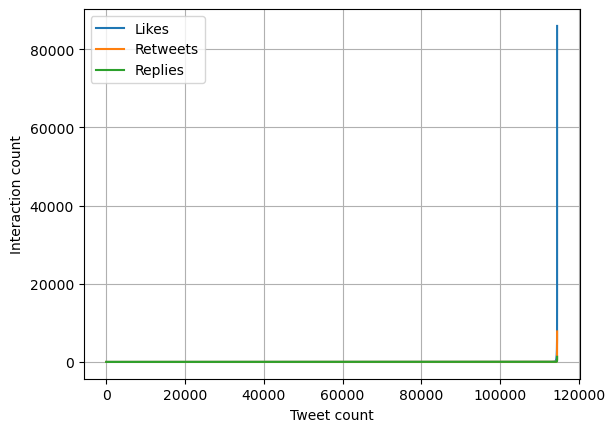

In [11]:
x = np.arange(0, data.shape[0])
plt.plot(x, data['Likes'].sort_values(ascending=True), label = "Likes") 
plt.plot(x, data['Retweets'].sort_values(ascending=True), label = 'Retweets')
plt.plot(x, data['Replies'].sort_values(ascending=True), label = 'Replies')
plt.xlabel("Tweet count")
plt.ylabel("Interaction count")

plt.grid()
plt.legend() 
plt.show()

* Dựa vào biểu đồ ở trên, chúng ta có thể thấy rằng người dùng có xu hướng sử dụng tương tác like (có thể vì đây là phương thức tương tác dễ thực hiện nhất) và có xu hướng hạn chế bình luận.
* Đa số các tweet được tạo ra nhưng không có sự tương tác và số lần tương tác tập trung ở một vài tweet nhất định. Một giả thiết cho hiện tượng này là các sự kiện mà nhà phát hành tổ chức cho trò chơi Fantasy Premier League. Các sự kiện yêu cầu sự tương tác của người chơi (like, chia sẻ sự kiện thông qua tweet, bình luận, sử dụng hashtag) để có thể nhận được vật phẩm từ sự kiện.
* Những tương tác tập trung chủ yếu ở các tweet của nhà phát hành (các trang chính thức). Những tweet chia sẻ sự kiện là những tweet không có tính mới mẻ và lặp đi lặp lại nên khó có thể thu hút các người dùng khác.